# Telling a Story with Data

In this notebook, I'll show you how to use the tools we've learned to pose a sociological question, find and read appropriate data, and then do a series of analyses that form an answer to the question. Through this process, we'll keep the principles of *Data Feminism* in mind.



The data source I identified as relevant to my question is IPUMS at the University of Minnesota: https://usa.ipums.org/usa/index.shtml

IPUMS is a form of US Census data that is made available to researchers, with identifying information removed. IPUMS used to stand for "Integrated Public Use Microdata Series" but now people just consider it the name of a data source. It allows us to ask many different kinds of questions about the US population, including individual adults and households. It is a popular data source for many kinds of sociological research.



In [ ]:
# Code block 1: Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sb
import matplotlib.pyplot as plt 
import math


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Code block 1b: Install library
!pip install researchpy

In [ ]:
# Code block 1c: Importing the new library
import researchpy as rp

In [ ]:
# Code block 2: Reading the data
IPUMS_df = pd.read_csv('/content/drive/MyDrive/Data/usa_00003.csv')


In [ ]:
IPUMS_df.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,REGION,STATEICP,STATEFIP,COUNTYICP,COUNTYFIP,DENSITY,METRO,MET2013,MET2013ERR,METPOP10,PCTMETRO,CITY,CITYERR,CITYPOP,PUMA,STRATA,GQ,GQTYPE,GQTYPED,FARM,OWNERSHP,OWNERSHPD,MORTGAGE,MORTGAG2,FARMPROD,ACREHOUS,MORTAMT1,MORTAMT2,TAXINCL,INSINCL,PROPINSR,PROPTX99,OWNCOST,RENT,...,CLASSWKRD,OCC2010,INDNAICS,WKSWORK1,WKSWORK2,UHRSWORK,WRKLSTWK,LOOKING,INCTOT,FTOTINC,INCWAGE,INCBUS00,INCSS,INCWELFR,INCINVST,INCRETIR,INCSUPP,INCOTHER,INCEARN,POVERTY,OCCSCORE,SEI,HWSEI,PRESGL,MIGRATE1,MIGRATE1D,MIGCOUNTY1,VETDISAB,DIFFREM,DIFFPHYS,DIFFMOB,DIFFCARE,DIFFSENS,DIFFEYE,DIFFHEAR,PWTYPE,CARPOOL,RIDERS,TRANTIME,DEPARTS
0,2019,201901,5,2019010000205,1065.3,2019000000051,32,41,1,970,97,2341.6,4,33660,1,412992,100.0,0,0,0,2701,270101,3,1,100,1,0,0,0,0,0,0,0,0,0,0,0,0,99999,0,...,0,9920,0,0,0,0,3,3,0,9999999,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2.0,23.0,97.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2019,201901,25,2019010001133,1346.7,2019000000251,32,41,1,0,0,86.9,1,0,0,62817,0.0,0,0,0,400,40001,3,1,100,1,0,0,0,0,0,0,0,0,0,0,0,0,99999,0,...,22,4220,5313,0,0,0,3,3,0,9999999,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,9.0,19.56,16.1,3.0,31.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2019,201901,45,2019010002777,241.2,2019000000451,32,41,1,0,0,224.6,4,26620,5,417593,100.0,0,0,0,200,20001,4,5,500,1,0,0,0,0,0,0,0,0,0,0,0,0,99999,0,...,0,9920,0,0,0,0,1,1,10100,9999999,0,0,10100,0,0.0,0.0,0.0,0.0,0.0,77.0,0.0,0.0,0.00,0.0,1.0,10.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2019,201901,65,2019010004483,1326.6,2019000000651,32,41,1,970,97,2341.6,4,33660,1,412992,100.0,0,0,0,2701,270101,3,1,100,1,0,0,0,0,0,0,0,0,0,0,0,0,99999,0,...,0,9920,0,0,0,0,3,3,0,9999999,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,10.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2019,201901,86,2019010005917,381.9,2019000000861,32,41,1,730,73,2731.2,4,13820,6,1128047,100.0,0,0,0,1301,130101,3,1,100,1,0,0,0,0,0,0,0,0,0,0,0,0,99999,0,...,0,9920,0,0,0,0,3,3,12900,9999999,0,0,12900,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,10.0,0.0,0.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


Here are parts of the codebook that I'll use for this analysis.

```
# This is formatted as code
CINETHH		Access to internet
0		N/A (GQ)
1		Yes, with a subscription to an Internet Service
2		Yes, without a subscription to an Internet Service
3		No Internet access at this house, apartment, or mobile home
```

```
# This is formatted as code
CISMRTPHN		Smartphone
0		N/A (GQ)
1		Yes
2		No
```

```
# This is formatted as code
RACE		Race [general version]
1		White
2		Black/African American/Negro
3		American Indian or Alaska Native
4		Chinese
5		Japanese
6		Other Asian or Pacific Islander
7		Other race, nec
8		Two major races
9		Three or more major races
```

```
# This is formatted as code
EDUC		Educational attainment [general version]
00		N/A or no schooling
01		Nursery school to grade 4
02		Grade 5, 6, 7, or 8
03		Grade 9
04		Grade 10
05		Grade 11
06		Grade 12
07		1 year of college
08		2 years of college
09		3 years of college
10		4 years of college
11		5+ years of college
```






Using the national sample that IPUMS represents--and aware of its limitations--I want to investigate how race and class related to technology use. I have two variables that measure technology use in the dataset: internet access and smartphone use. I am using an educational attainment variable, recoded, as the proxy for social class. I am mindful of the problematic way that the US Census measures race, but I'll begin there.

In [ ]:
# Code block 3: Analysis
crosstab, sigtab = rp.crosstab(IPUMS_df.CINETHH, IPUMS_df.EDUC, prop='col', test='chi-square')
crosstab

EDUC                          ...                                
EDUC          0       1       2       3  ...       8      10      11     All
CINETHH                                  ...                                
0          5.38    2.21    7.14   13.16  ...    6.58    3.97    3.00    9.96
1         84.50   90.53   81.20   73.68  ...   86.98   92.55   94.31   80.98
2          2.12    0.86    2.38    2.96  ...    1.74    1.04    1.03    1.82
3          8.00    6.40    9.27   10.20  ...    4.70    2.44    1.65    7.24
All      100.00  100.00  100.00  100.00  ...  100.00  100.00  100.00  100.00

[5 rows x 12 columns]

In [ ]:
sigtab

,Chi-square test,results
0,Pearson Chi-square ( 30.0) =,677.9369
1,p-value =,0.0000
2,Cramer's V =,0.1380


In [ ]:
crosstab, sigtab = rp.crosstab(IPUMS_df.CINETHH, IPUMS_df.RACE, prop='col', test='chi-square')
crosstab

RACE                          ...                                
RACE          1       2       3       4  ...       7       8       9     All
CINETHH                                  ...                                
0          7.91   18.34    8.15   12.72  ...   16.32   12.40   21.05    9.96
1         83.55   66.98   70.79   83.77  ...   75.11   80.88   76.32   80.98
2          1.87    2.26    2.25    1.32  ...    1.27    1.81    0.00    1.82
3          6.66   12.42   18.82    2.19  ...    7.31    4.91    2.63    7.24
All      100.00  100.00  100.00  100.00  ...  100.00  100.00  100.00  100.00

[5 rows x 10 columns]

In [ ]:
sigtab

,Chi-square test,results
0,Pearson Chi-square ( 24.0) =,350.4059
1,p-value =,0.0000
2,Cramer's V =,0.0992


In [ ]:
crosstab, sigtab = rp.crosstab(IPUMS_df.CINETHH, IPUMS_df.HISPAN, prop='col', test='chi-square')
crosstab

HISPAN                                        
HISPAN        0       1       2       3       4     All
CINETHH                                                
0          9.18   11.96   14.06    8.70   18.11    9.96
1         81.91   77.77   73.44   82.61   76.22   80.98
2          1.81    1.98    1.56    0.00    1.35    1.82
3          7.09    8.30   10.94    8.70    4.32    7.24
All      100.00  100.00  100.00  100.00  100.00  100.00

In [ ]:
sigtab

,Chi-square test,results
0,Pearson Chi-square ( 12.0) =,54.8581
1,p-value =,0.0000
2,Cramer's V =,0.0393


In [ ]:
crosstab, sigtab = rp.crosstab(IPUMS_df.CISMRTPHN, IPUMS_df.EDUC, prop='col', test='chi-square')
crosstab

EDUC                          ...                                
EDUC            0       1       2       3  ...       8      10      11     All
CISMRTPHN                                  ...                                
0            5.38    2.21    7.14   13.16  ...    6.58    3.97    3.00    9.96
1           87.75   93.60   86.84   76.64  ...   87.11   91.33   92.24   81.77
2            6.88    4.18    6.02   10.20  ...    6.31    4.70    4.76    8.27
All        100.00  100.00  100.00  100.00  ...  100.00  100.00  100.00  100.00

[4 rows x 12 columns]

In [ ]:
sigtab

,Chi-square test,results
0,Pearson Chi-square ( 20.0) =,624.2106
1,p-value =,0.0000
2,Cramer's V =,0.1622


In [ ]:
crosstab, sigtab = rp.crosstab(IPUMS_df.CISMRTPHN, IPUMS_df.RACE, prop='col', test='chi-square')
crosstab

RACE                          ...                                
RACE            1       2       3       4  ...       7       8       9     All
CISMRTPHN                                  ...                                
0            7.91   18.34    8.15   12.72  ...   16.32   12.40   21.05    9.96
1           84.02   70.46   69.38   85.09  ...   77.07   82.69   78.95   81.77
2            8.07   11.19   22.47    2.19  ...    6.61    4.91    0.00    8.27
All        100.00  100.00  100.00  100.00  ...  100.00  100.00  100.00  100.00

[4 rows x 10 columns]

In [ ]:
sigtab

,Chi-square test,results
0,Pearson Chi-square ( 16.0) =,326.5484
1,p-value =,0.0000
2,Cramer's V =,0.1173


In [ ]:
crosstab, sigtab = rp.crosstab(IPUMS_df.CISMRTPHN, IPUMS_df.HISPAN, prop='col', test='chi-square')
crosstab

HISPAN                                        
HISPAN          0       1       2       3       4     All
CISMRTPHN                                                
0            9.18   11.96   14.06    8.70   18.11    9.96
1           81.61   83.50   84.38   86.96   75.41   81.77
2            9.20    4.55    1.56    4.35    6.49    8.27
All        100.00  100.00  100.00  100.00  100.00  100.00

In [ ]:
sigtab

,Chi-square test,results
0,Pearson Chi-square ( 8.0) =,91.4685
1,p-value =,0.0000
2,Cramer's V =,0.0621


In [ ]:
# Code block 4a: Separate cases for plotting
IPUMS2_df = IPUMS_df.loc[lambda IPUMS_df: IPUMS_df['RACE'] == 1, :] # Selecting cases: RACE == 1, White
IPUMS3_df = IPUMS_df.loc[lambda IPUMS_df: IPUMS_df['RACE'] == 2, :] # Selecting cases: RACE == 2, Black
IPUMS4a_df = IPUMS_df.loc[lambda IPUMS_df: IPUMS_df['RACE'] == 4 , :] # Selecting cases: RACE > 3 & < 7, Asian
IPUMS4b_df = IPUMS_df.loc[lambda IPUMS_df: IPUMS_df['RACE'] == 5 , :] # Selecting cases: RACE > 3 & < 7, Asian
IPUMS4c_df = IPUMS_df.loc[lambda IPUMS_df: IPUMS_df['RACE'] == 6, :] # Selecting cases: RACE > 3 & < 7, Asian
IPUMS4_df = pd.concat([IPUMS4a_df, IPUMS4b_df, IPUMS4c_df], axis=0)


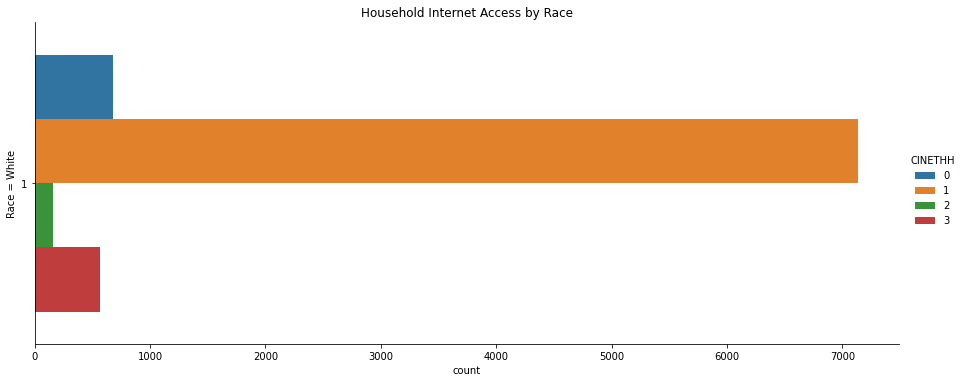

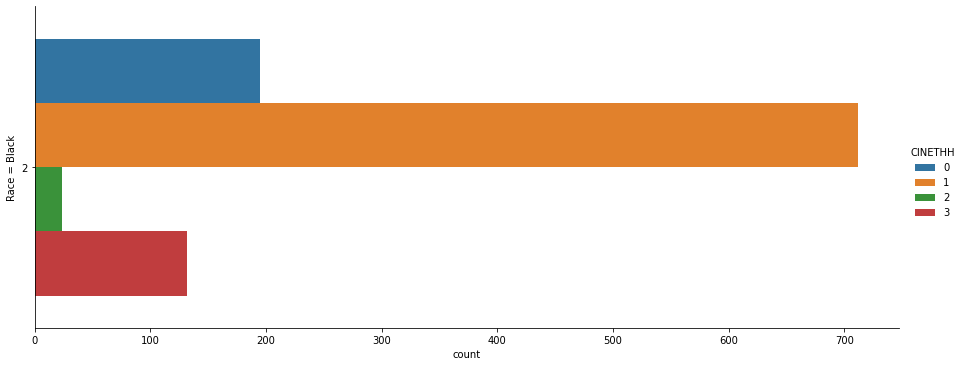

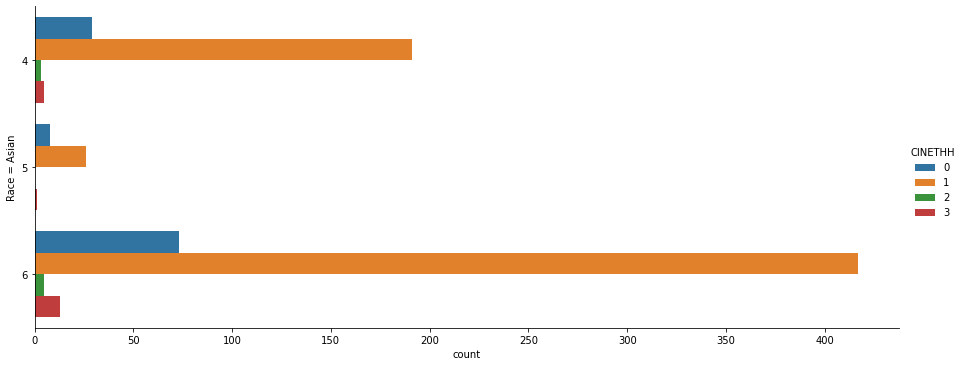

In [ ]:
# Code block 4b: Visualization
sb.catplot(hue='CINETHH', y='RACE', kind='count', height=5, aspect=2.5, data=IPUMS2_df)
plt.ylabel('Race = White')
plt.title('Household Internet Access by Race')
sb.catplot(hue='CINETHH', y='RACE', kind='count', height=5, aspect=2.5, data=IPUMS3_df)
plt.ylabel('Race = Black')
sb.catplot(hue='CINETHH', y='RACE', kind='count', height=5, aspect=2.5, data=IPUMS4_df)
plt.ylabel('Race = Asian')
plt.show()

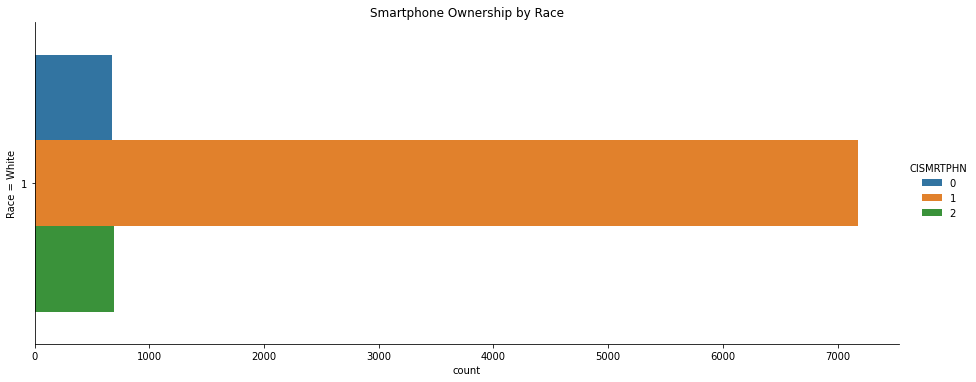

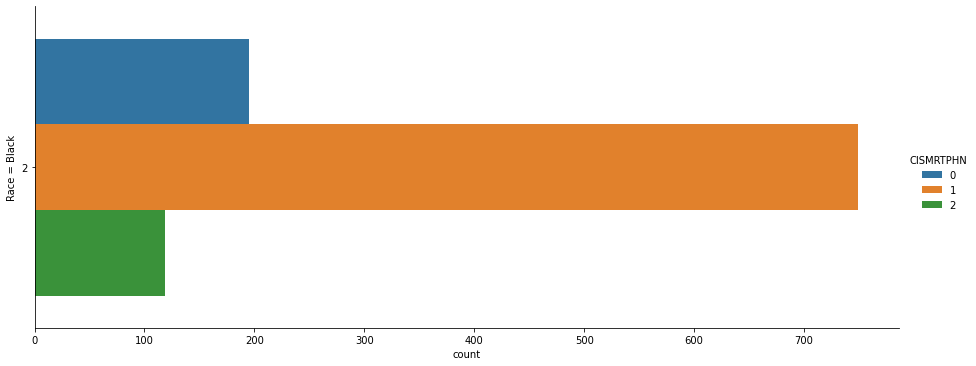

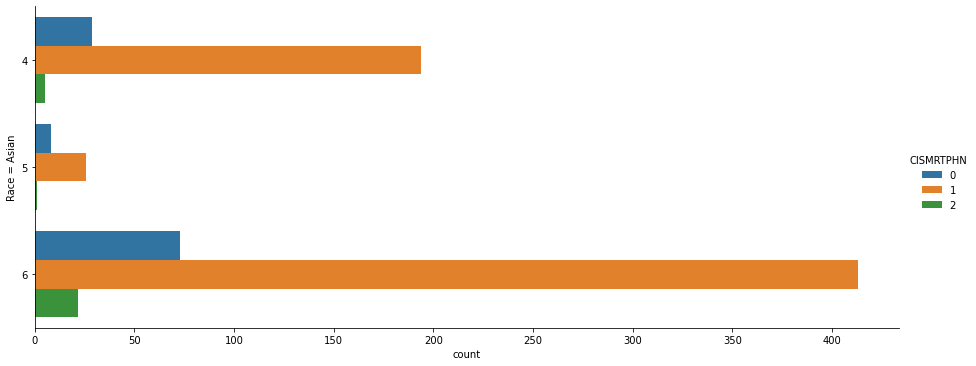

In [ ]:
# Code block 4c: Visualization
sb.catplot(hue='CISMRTPHN', y='RACE', kind='count', height=5, aspect=2.5, data=IPUMS2_df)
plt.ylabel('Race = White')
plt.title('Smartphone Ownership by Race')
sb.catplot(hue='CISMRTPHN', y='RACE', kind='count', height=5, aspect=2.5, data=IPUMS3_df)
plt.ylabel('Race = Black')
sb.catplot(hue='CISMRTPHN', y='RACE', kind='count', height=5, aspect=2.5, data=IPUMS4_df)
plt.ylabel('Race = Asian')
plt.show()

In [ ]:
# Code block 4d: Separate cases for plotting
IPUMS5_df = IPUMS_df.loc[lambda IPUMS_df: IPUMS_df['EDUC'] <= 6, :] # Selecting cases: EDUC < 6, HS or less
IPUMS6_df = IPUMS_df.loc[lambda IPUMS_df: IPUMS_df['EDUC'] >= 7, :] # Selecting cases: EDUC > 7, College


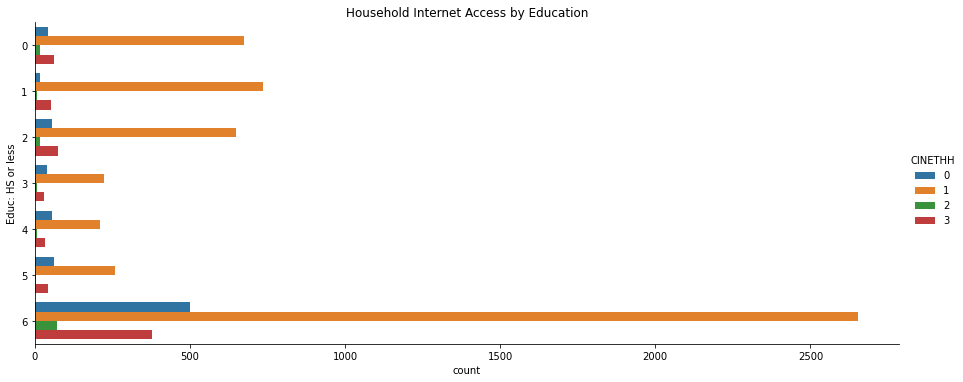

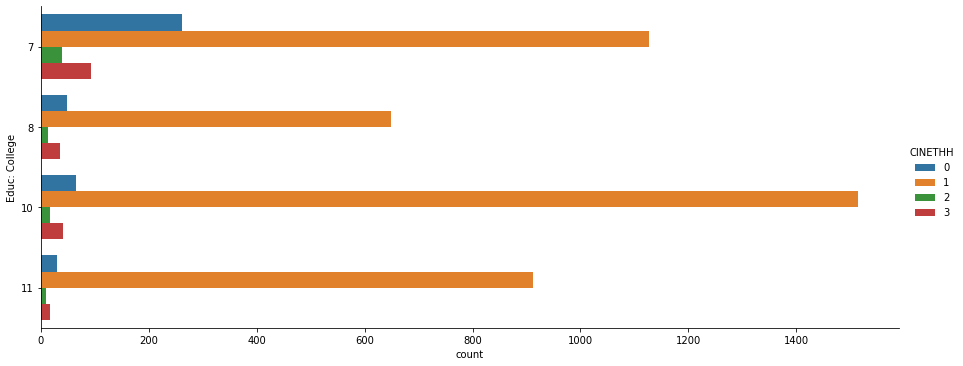

In [ ]:
# Code block 4d: Visualization
sb.catplot(hue='CINETHH', y='EDUC', kind='count', height=5, aspect=2.5, data=IPUMS5_df)
plt.ylabel('Educ: HS or less')
plt.title('Household Internet Access by Education')
sb.catplot(hue='CINETHH', y='EDUC', kind='count', height=5, aspect=2.5, data=IPUMS6_df)
plt.ylabel('Educ: College')
plt.show()

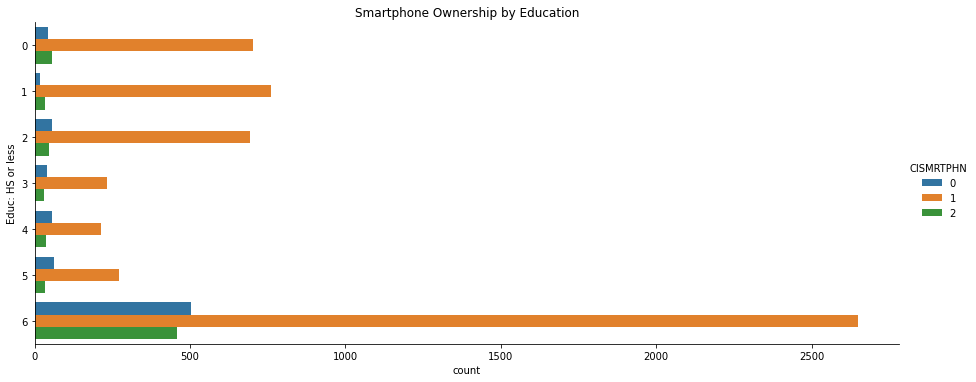

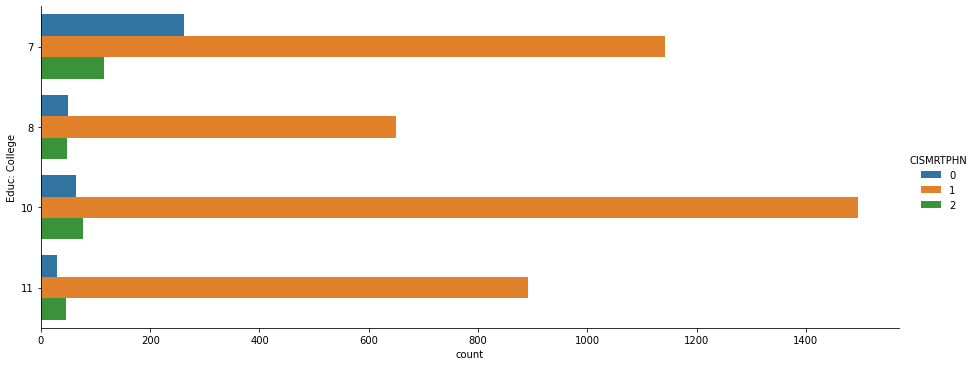

In [ ]:
# Code block 4d: Visualization
sb.catplot(hue='CISMRTPHN', y='EDUC', kind='count', height=5, aspect=2.5, data=IPUMS5_df)
plt.ylabel('Educ: HS or less')
plt.title('Smartphone Ownership by Education')
sb.catplot(hue='CISMRTPHN', y='EDUC', kind='count', height=5, aspect=2.5, data=IPUMS6_df)
plt.ylabel('Educ: College')
plt.show()

## Activity
1. Find an open data source related to a question about science or technology. (It could be one that we've used before, or one that you have found.) Read in the data into a DataFrame.

2. Identify a question that you can answer with variables in the data.

3. Produce tables or graphs that represent an attempt to answer the question with the data. As in the example above, you can mix tables and graphs. You should have at least two items of analysis.

4. Tell a story with the data analysis you've constructed, keeping in mind the key ideas from *Data Feminism*. This may include telling a story about what is absent from the data since power is related to counting, and not everything important is counted.